In [1]:
import tensorflow as tf
from tensorflow import keras


/opt/conda/envs/rapids/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/envs/rapids/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/envs/rapids/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/envs/rapids/lib/python3.6/site-packages/tensorflow/python/framework/dty

In [2]:
import pandas as pd
import numpy as np
import os

In [3]:
data=pd.read_csv('Crime_Clean.csv')

In [4]:
data['Crime Name3'].value_counts()

LARCENY - FROM AUTO                         20699
DRUGS - MARIJUANA - POSSESS                 14408
POLICE INFORMATION                          13417
ASSAULT - 2ND DEGREE                        12724
LARCENY - SHOPLIFTING                       12145
                                            ...  
FRAUD - WELFARE                                 1
STOLEN PROPERTY - TRANSPORT INTERSTATE          1
FALSE IMPRISONMENT - MINOR - PARENTAL           1
HUMAN TRAFFICKING - INVOLUNTARY SERITUDE        1
WEAPON - SELLING                                1
Name: Crime Name3, Length: 326, dtype: int64

In [5]:
classes = data['Crime Name3'].value_counts().loc[lambda x: x > 1000]

top_classes = list(classes.index.values)
top_classes

['LARCENY - FROM AUTO',
 'DRUGS - MARIJUANA - POSSESS',
 'POLICE INFORMATION',
 'ASSAULT - 2ND DEGREE',
 'LARCENY - SHOPLIFTING',
 'DRIVING UNDER THE INFLUENCE LIQUOR',
 'LARCENY (DESCRIBE OFFENSE)',
 'DAMAGE PROPERTY - PRIVATE',
 'MENTAL ILLNESS - EMERGENCY PETITION',
 'LARCENY - FROM BLDG',
 'LOST PROPERTY',
 'IDENTITY THEFT',
 'SUDDEN DEATH',
 'LIQUOR - POSSESS',
 'PUBLIC PEACE - DISORDERLY CONDUCT',
 'AUTO THEFT - VEHICLE THEFT',
 'LARCENY - AUTO PARTS',
 'MISSING PERSON',
 'TRESPASSING',
 'FRAUD - ILLEGAL USE CREDIT CARDS',
 'DAMAGE PROPERTY (DESCRIBE OFFENSE)',
 'MENTAL ILLNESS',
 'JUVENILE - RUNAWAY',
 'ASSAULT - SIMPLE',
 'BURGLARY - FORCED ENTRY-RESIDENTIAL',
 'FRAUD (DESCRIBE OFFENSE)',
 'RECOVERED PROPERTY - MONT CO.',
 'BURGLARY - NO FORCED ENTRY-RESIDENTIAL',
 'DRUGS - NARCOTIC EQUIP - POSSESS',
 'DRUGS - COCAINE - POSSESS',
 'FRAUD - CONFIDENCE GAME',
 'FRAUD - IMPERSONATION',
 'DAMAGE PROPERTY - BUSINESS',
 'LIQUOR (DESCRIBE OFFENSE)',
 'BURGLARY - FORCED ENTRY-NONRESIDE

In [33]:
data2 = data[data['Crime Name3'].isin(top_classes)]

In [34]:
len(data2)

202113

In [35]:
data2['Crime Name3'].value_counts()

LARCENY - FROM AUTO                           20699
DRUGS - MARIJUANA - POSSESS                   14408
POLICE INFORMATION                            13417
ASSAULT - 2ND DEGREE                          12724
LARCENY - SHOPLIFTING                         12145
DRIVING UNDER THE INFLUENCE LIQUOR            11747
LARCENY (DESCRIBE OFFENSE)                     9687
DAMAGE PROPERTY - PRIVATE                      9123
MENTAL ILLNESS - EMERGENCY PETITION            8595
LARCENY - FROM BLDG                            8310
LOST PROPERTY                                  8237
IDENTITY THEFT                                 4896
SUDDEN DEATH                                   4417
LIQUOR - POSSESS                               4411
PUBLIC PEACE - DISORDERLY CONDUCT              4318
AUTO THEFT - VEHICLE THEFT                     4149
LARCENY - AUTO PARTS                           4056
MISSING PERSON                                 3589
TRESPASSING                                    3378
FRAUD - ILLE

In [36]:
data2['target'] = data2['Crime Name3'].astype('category').cat.codes

/opt/conda/envs/rapids/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [37]:
data2['num_words'] = data2['Place'].apply(lambda x: len(x.split()))

/opt/conda/envs/rapids/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [38]:
data2['bins'] = pd.cut(data2['num_words'], bins=[0,5,10,15,20], labels=['0-5','5-10','10-15','15-20'])

/opt/conda/envs/rapids/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [39]:
word_dist = data2.groupby('bins').size().reset_index().rename(columns={0:'counts'})

In [40]:
word_dist.head()

,bins,counts
0,0-5,201561
1,5-10,552
2,10-15,0
3,15-20,0


In [41]:
num_class = len(np.unique(data2['target'].values))
y = data2['target'].values

In [42]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_len=10
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data2['Place'].values)
post_seq = tokenizer.texts_to_sequences(data2['Place'].values)
post_seq_padded = pad_sequences(post_seq,maxlen=max_len)

In [43]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(post_seq_padded,y,test_size=0.05)

In [44]:
vocab_size= len(tokenizer.word_index) + 1

In [45]:
inputs = tf.keras.Input(shape=(max_len,))
embedding_layer= tf.keras.layers.Embedding(vocab_size,
                          128,
                          input_length=max_len)(inputs)
x = tf.keras.layers.LSTM(64)(embedding_layer)
x = tf.keras.layers.Dense(64, activation='relu')(x)

predictions = tf.keras.layers.Dense(num_class, activation='softmax')(x)

model = tf.keras.Model(inputs=[inputs], outputs=predictions)
model.compile(optimizer='adam',
             loss='categorical_crossentropy',
             metrics=['acc'])

In [46]:
y= tf.keras.utils.to_categorical(y_train)

In [49]:
history = model.fit([x_train],y, batch_size=128, verbose=1, validation_split=0.25,shuffle=True, epochs=5)

Train on 144005 samples, validate on 48002 samples
Epoch 1/5
144005/144005 [==============================] - 39s 272us/sample - loss: 2.6001 - acc: 0.2768 - val_loss: 2.4991 - val_acc: 0.2958
Epoch 2/5
144005/144005 [==============================] - 39s 269us/sample - loss: 2.4915 - acc: 0.2927 - val_loss: 2.4806 - val_acc: 0.2874
Epoch 3/5
144005/144005 [==============================] - 39s 271us/sample - loss: 2.4802 - acc: 0.2937 - val_loss: 2.4760 - val_acc: 0.2957
Epoch 4/5
144005/144005 [==============================] - 39s 270us/sample - loss: 2.4758 - acc: 0.2934 - val_loss: 2.4720 - val_acc: 0.2976
Epoch 5/5
144005/144005 [==============================] - 39s 269us/sample - loss: 2.4727 - acc: 0.2940 - val_loss: 2.4731 - val_acc: 0.2894


In [50]:
predictions = model.predict(x_test)

In [53]:
predictions[:,1]

array([0.19279537, 0.08014688, 0.19279537, ..., 0.00934381, 0.12757492,
       0.08924975], dtype=float32)

In [54]:
predictions[:,2]

array([0.03566139, 0.01461639, 0.03566139, ..., 0.0026579 , 0.02758371,
       0.02361132], dtype=float32)

In [56]:
y_test2 = tf.keras.utils.to_categorical(y_test)
y_test2[:,1]

array([0., 0., 1., ..., 0., 1., 0.], dtype=float32)

/opt/conda/envs/rapids/lib/python3.6/site-packages/ipykernel_launcher.py:25: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


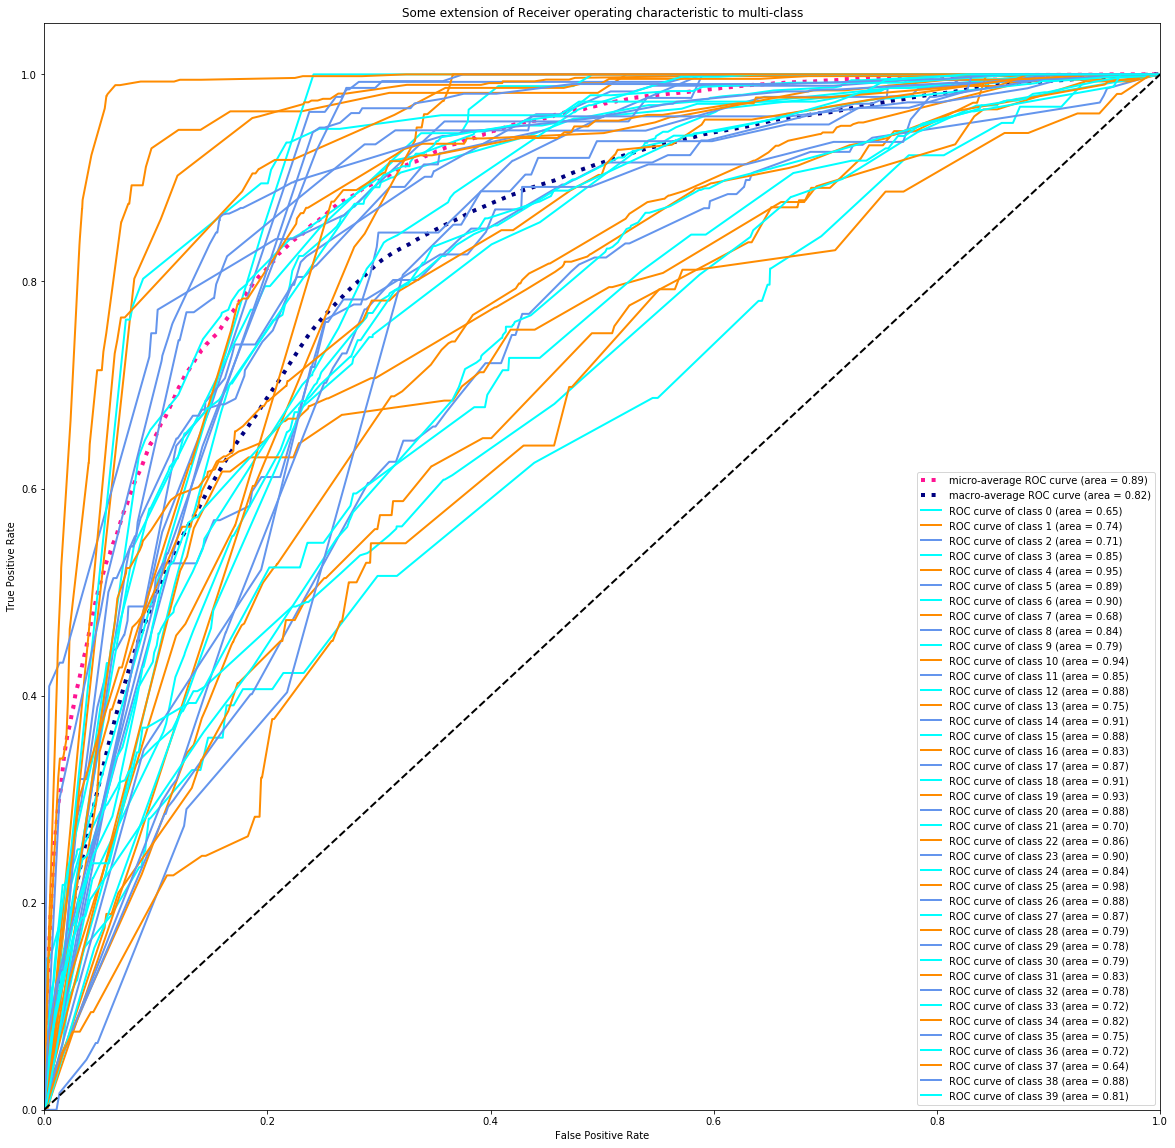

In [63]:
from sklearn.metrics import roc_curve, auc
from scipy import interp
from itertools import cycle
import matplotlib.pyplot as plt

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(top_classes)):
    fpr[i], tpr[i], _ = roc_curve(y_test2[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test2.ravel(), predictions.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(top_classes))]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(len(top_classes)):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= len(top_classes)

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(len(top_classes)), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
fig = plt.gcf()
fig.set_size_inches(20,20)
plt.show()



In [65]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

# For each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(len(top_classes)):
    precision[i], recall[i], _ = precision_recall_curve(y_test2[:, i],
                                                        predictions[:, i])
    average_precision[i] = average_precision_score(y_test2[:, i], predictions[:, i])

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(y_test2.ravel(),
    predictions.ravel())
average_precision["micro"] = average_precision_score(y_test2, predictions,
                                                     average="micro")
print('Average precision score, micro-averaged over all classes: {0:0.2f}'
      .format(average_precision["micro"]))

Average precision score, micro-averaged over all classes: 0.27


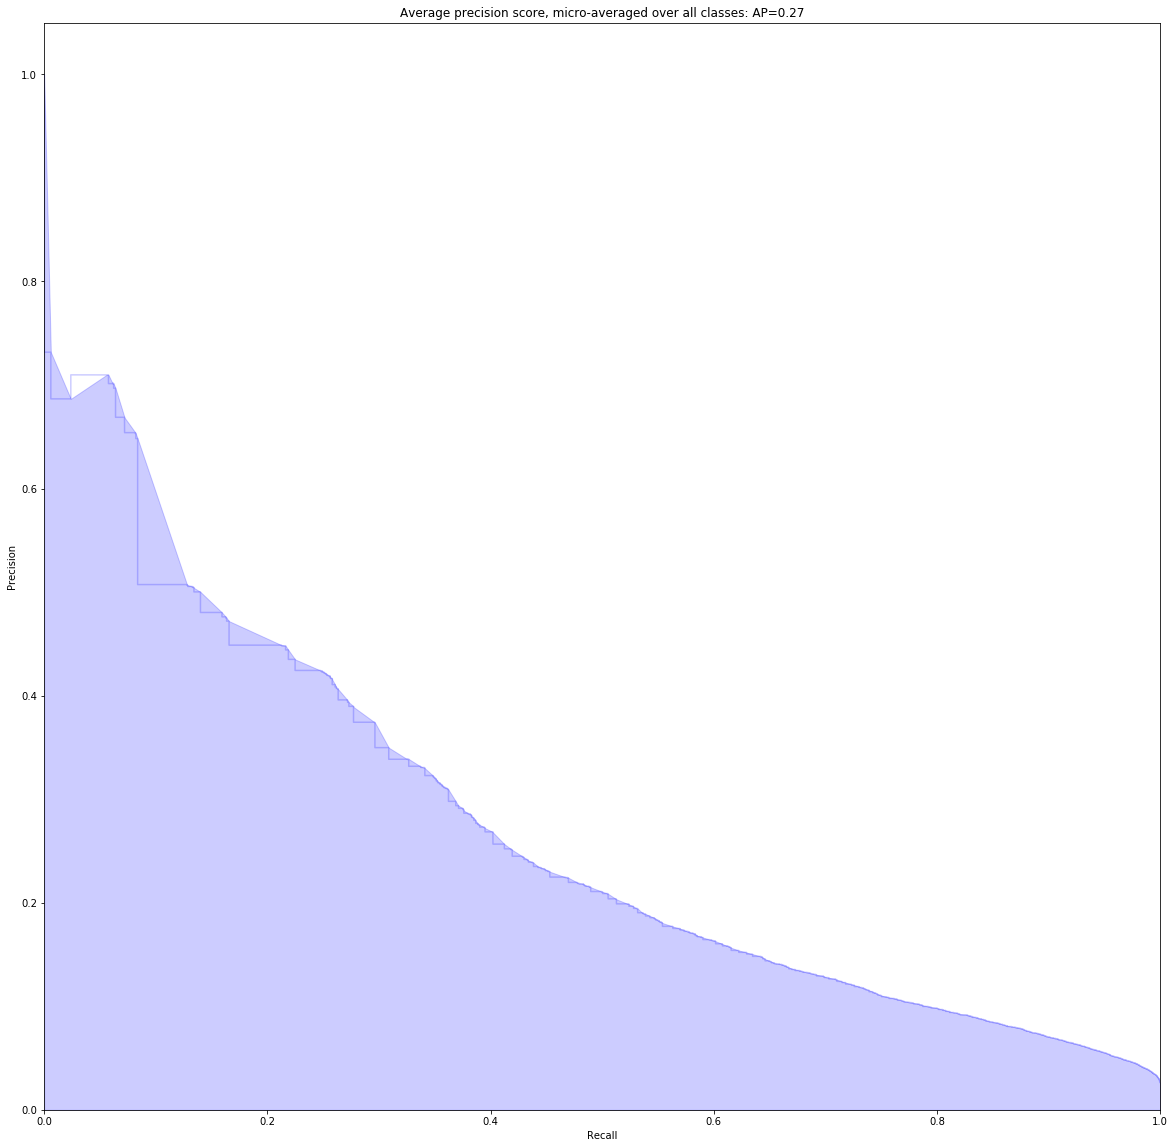

In [67]:
plt.figure()
plt.step(recall['micro'], precision['micro'], color='b', alpha=0.2,
         where='post')
plt.fill_between(recall["micro"], precision["micro"], alpha=0.2, color='b')#,
                 #**step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(
    'Average precision score, micro-averaged over all classes: AP={0:0.2f}'
    .format(average_precision["micro"]))
fig = plt.gcf()
fig.set_size_inches(20,20)

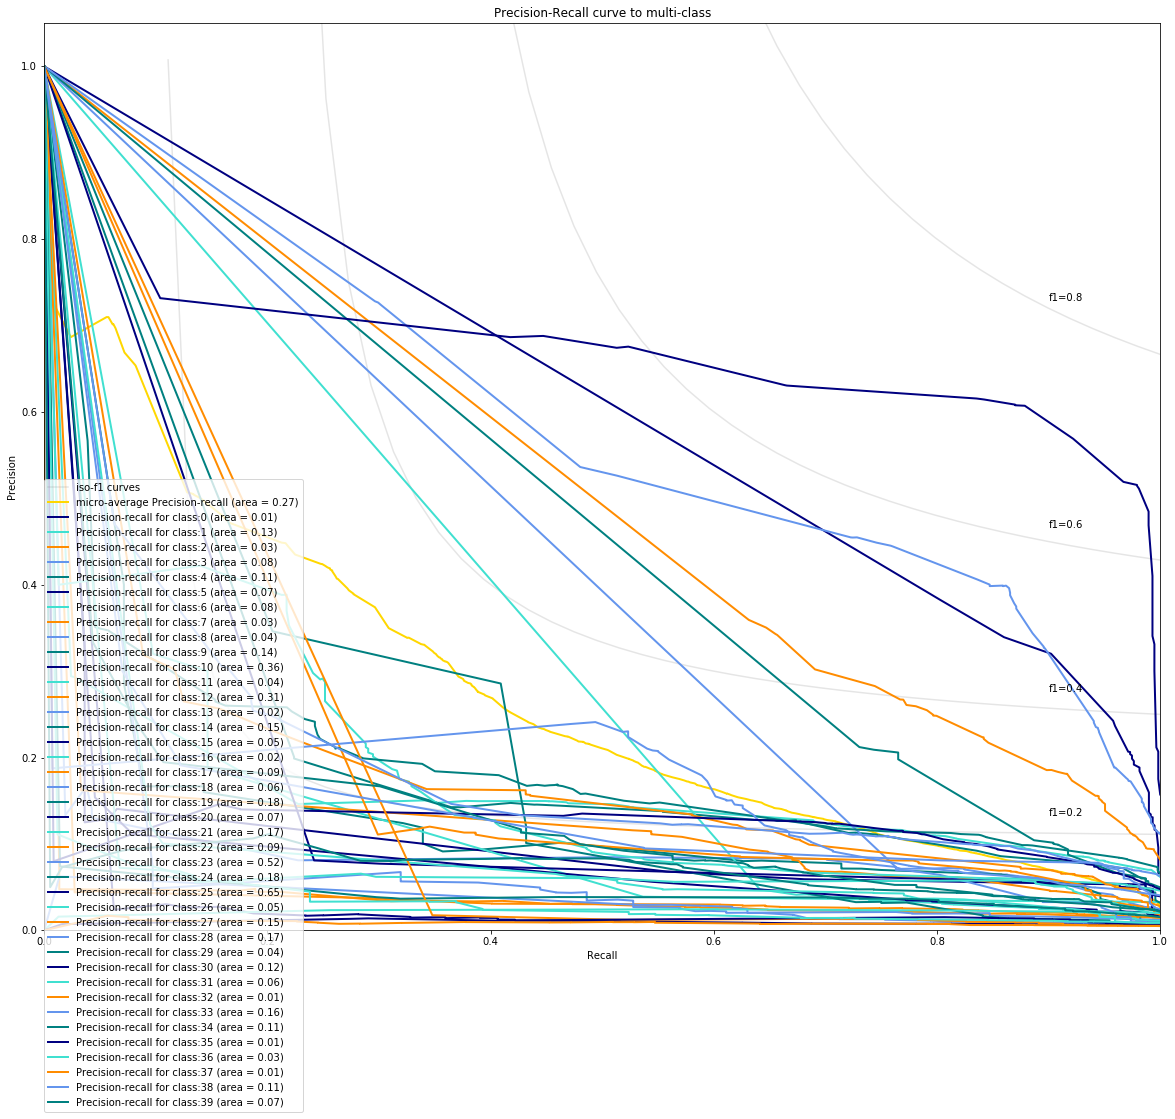

In [69]:
from itertools import cycle
# setup plot details
colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])

plt.figure(figsize=(14, 8))
f_scores = np.linspace(0.2, 0.8, num=4)
lines = []
labels = []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
    plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

lines.append(l)
labels.append('iso-f1 curves')
l, = plt.plot(recall["micro"], precision["micro"], color='gold', lw=2)
lines.append(l)
labels.append('micro-average Precision-recall (area = {0:0.2f})'
              ''.format(average_precision["micro"]))

for i, color in zip(range(len(top_classes)), colors):
    l, = plt.plot(recall[i], precision[i], color=color, lw=2)
    lines.append(l)
    labels.append('Precision-recall for class:{0} (area = {1:0.2f})'
                  ''.format(i, average_precision[i]))

fig = plt.gcf()
fig.subplots_adjust(bottom=0.25)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve to multi-class')
plt.legend(lines, labels, loc=(0, -.2), prop=dict(size=10))
fig = plt.gcf()
fig.set_size_inches(20,20)

plt.show()

In [72]:
from sklearn.metrics import roc_auc_score

y_prob = model.predict(x_test)

macro_roc_auc_ovo = roc_auc_score(y_test2, y_prob, multi_class="ovo",
                                  average="macro")
weighted_roc_auc_ovo = roc_auc_score(y_test2, y_prob, multi_class="ovo",
                                     average="weighted")
macro_roc_auc_ovr = roc_auc_score(y_test2, y_prob, multi_class="ovr",
                                  average="macro")
weighted_roc_auc_ovr = roc_auc_score(y_test2, y_prob, multi_class="ovr",
                                     average="weighted")
print("One-vs-One ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)"
      .format(macro_roc_auc_ovo, weighted_roc_auc_ovo))
print("One-vs-Rest ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)"
      .format(macro_roc_auc_ovr, weighted_roc_auc_ovr))

One-vs-One ROC AUC scores:
0.824878 (macro),
0.834152 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.824878 (macro),
0.834152 (weighted by prevalence)
